# Web Assay Demo
This notebook walks through a general use case for the Web Assay. This includes initializing the web assay class with custom parsers, staining rendered pages to spot check, and creating paintings which are visual references for how the images are stained.

This is the workflow we employ for our experiment:

<img src='../data/assets/assay-flow.png'>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import glob
import inspect
import random
sys.path.append('..')

from PIL import Image
import numpy as np

import utils.parsers as P
from utils.config import cat2color, window_size, user_agent
from utils.web_assay import GoogleWebAssay, paint_abstract_representation

In [3]:
# inputs
term = 'john-cho'
fn_input = f'../data/test/input_local_searches/{term}.html'

# outputs
fn_metadata = f'../data/test/intermediate_local_searches/{term}-parsed.jsonl'
fn_screenshot = f'../data/test/intermediate_local_searches/{term}-screenshot.png'
fn_abstract_painting = f'../data/test/intermediate_local_searches/{term}-abstract.png'
fn_stained_screenshot = f'../data/test/intermediate_local_searches/{term}-stained.png'
os.makedirs('../data/test/intermediate_local_searches/', exist_ok=True)

# Setting to False displays the browser.
# If this is set to True, pyvirtualdisplay must be properly installed.
headless = False

In [4]:
# this imports each parser function into a list.
parser_functions = [
    o[1] for o in inspect.getmembers(P)
    if inspect.isfunction(o[1]) and
    '_parser' in o[0]
]
len(parser_functions)

68

In [5]:
# an example of a parser:
parser_functions[0]

<function utils.parsers.ads_aria_parser(body: bs4.element.Tag) -> List[Dict]>

## Initalizing and running Web Assay

In [6]:
assay = GoogleWebAssay(user_agent = user_agent,
                       window_size = window_size,
                       parser_functions = parser_functions,
                       color_palette = cat2color,
                       headless = headless)

In [7]:
# you can either visit pages in the browser manually, programmatically, or open saved HTML.
assay.open_local_html(fn_input)

You can use `assay.run` to parse the page. You can use the `stain` argument to color in elements.
This is useful for spot checking. Further you can inspect an element and see how it was labelled.

In [8]:
assay.run(stain=True)

`stain` can be set to specific categories(organic|link|ads|amp|answer) to selectively parse and stain just that category.

```
assay.run(stain='organic')
```

Beyond spot checking and development, `stain` should be set to `False` (which is a lot faster, since stain involves injecting custom style attributes in the HTML).

After running this function, the parsed metadata is stored in the `element_metadata` attribute, which is a Pandas dataframe.

In [9]:
df = assay.element_metadata
df.head()

,text,link,domain,xpath,element_class,category,element,tag,attrs,dimensions,location,area,area_page,fn_input
0,AdAd·www.thegrudge.movie/The Grudge | Watch th...,None,google.com,/html/body/div[10]/div/div[6]/div/div[1]/div[2...,C4eCVc|c,ads-aria,"[[Ad], [[<div data-hveid=""CBIQAA""><div class=""...",div,"{'class': ['C4eCVc', 'c'], 'id': 'tads', 'aria...","{'height': 343.1000061035156, 'width': 344.0}","{'x': 8, 'y': 166}",118026.4021,118026.4021,None
1,John ChoHis life in images,https://www.google.com/search/static/gs/m03l3j...,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,KDlObe|amp_r,amp-visual_stories,"[[[<div class=""iJXt7e""><div class=""Gkvhhd""> <d...",a,"{'class': ['KDlObe', 'amp_r'], 'href': 'https:...","{'height': 72.0, 'width': 312.0}","{'x': 24, 'y': 1072}",0.0000,22464.0000,None
2,,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,swKmGc|y3tzvc|oRJe3d|r-iim9jiQmDSiU,link-button,"[ , [[<path d=""M12 4l-1.41 1.41L16.17 11H4v2h1...",a,"{'class': ['swKmGc', 'y3tzvc', 'oRJe3d', 'r-ii...","{'height': 52.0, 'width': 60.0}","{'x': 292, 'y': 1374}",0.0000,3120.0000,None
3,View all,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,oRJe3d|r-i6_uL7pDs5eA,link-button,"[ , [[<span class=""PUDfGe z1asCe lYxQe""><svg f...",a,"{'class': ['oRJe3d', 'r-i6_uL7pDs5eA'], 'role'...","{'height': 86.44999694824219, 'width': 58.0}","{'x': 876, 'y': 1544}",0.0000,0.0000,None
4,,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,swKmGc|y3tzvc|oRJe3d|r-iO5LDsioyRPE,link-button,"[ , [[<path d=""M12 4l-1.41 1.41L16.17 11H4v2h1...",a,"{'class': ['swKmGc', 'y3tzvc', 'oRJe3d', 'r-iO...","{'height': 52.0, 'width': 60.0}","{'x': 292, 'y': 1742}",0.0000,3120.0000,None


Dataframes like this are used for our analysis. Below is an example of how much area (in percentage of all area) is covered by each element we parsed from this page:

In [10]:
( df.groupby(['category']).area_page.sum() / 
  df.area_page.sum() ).sort_values(ascending=False)

category
organic-search_result_1a           0.371308
link-google                        0.203936
amp-search_result_3                0.081583
ads-aria                           0.071772
link-youtube                       0.057777
answer-expand_2                    0.057468
link-img_reverse                   0.036165
amp-card                           0.025939
answer-knowledge_panel_answer_1    0.021511
answer-knowledge_graph_factoid     0.017999
organic                            0.016795
amp-visual_stories                 0.013660
link-knowledge_panel_tab           0.010596
answer-expand_3                    0.007322
link-button                        0.005692
link-load_more                     0.000477
Name: area_page, dtype: float64

## Selenium native functions
Web Assay is built with Selenium, you can call `assay.driver` to access the Selenium driver.

In [11]:
# refresh the page
assay.driver.refresh()
time.sleep(1)

# scroll down 2000 pixels
assay.driver.execute_script("window.scrollTo(0, 2000);")
time.sleep(3)

# return to the top of the page
assay.driver.execute_script("window.scrollTo(0, 0);")

# let's also save the metadata
assay.run(stain=False)
assay.element_metadata.to_json(fn_metadata,
                               orient='records',
                               lines=True)

We will use the Selenium driver to take a full-page screenshot, this is baked into Web Assay as a function.

In [12]:
assay.screenshot_full(fn_screenshot)

Let's take a peek at the screenshot:

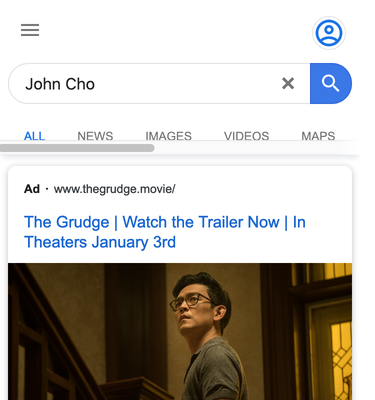

In [13]:
Image.open(fn_screenshot).crop([0 ,0, 375, 400])

## Creating visual artifacts
We can use the spatial metadata stored in `assay.element_metadata`, as well as the full screenshot to get an accurate portrayal of how Web Assay categorizes elements on the page.

To do with we use `paint_abstract_representation` to create paintings of the Web Assay's categorization. This function is a wrapper around a p5 script. p5 is a drawing library, and not very function-friendly. That is why we've made a functional wrapper around a script.

This method is more accurate than what you might see when you observe `assay.run(stain=True)`. Unlike the stain in the emulated web page, the p5 script will properly stain images within the web page, and get draw the correct shape of text `span`'s. Although the emulated stain is not completely accurate, `assay.element_metadata` is. This is just due to limitations in HTML style.

In [14]:
error_msg = "Something went wrong with the p5 scriped called in `../utils/draw_img.py`, did you download GLFW? You can copy and paste the python command and run it from the terminal to get an error messsage."

In [15]:
# Painting shapes ontop of the screenshot. 
resp = paint_abstract_representation(fn_metadata=fn_metadata,
                                     fn_out=fn_stained_screenshot,
                                     fn_img=fn_screenshot,
                                     verbose=True)
if not resp:
    print(error_msg)
resp

python ../utils/draw_img.py --input ../data/test/intermediate_local_searches/john-cho-parsed.jsonl --output ../data/test/intermediate_local_searches/john-cho-stained.png --img ../data/test/intermediate_local_searches/john-cho-screenshot.png --verbose 1


b'File ../data/test/intermediate_local_searches/john-cho-stained.png exists.\n'

# Let's preview what the paintings look like
We use the stained screenshots for spot checking Web Assay in our error analysis.

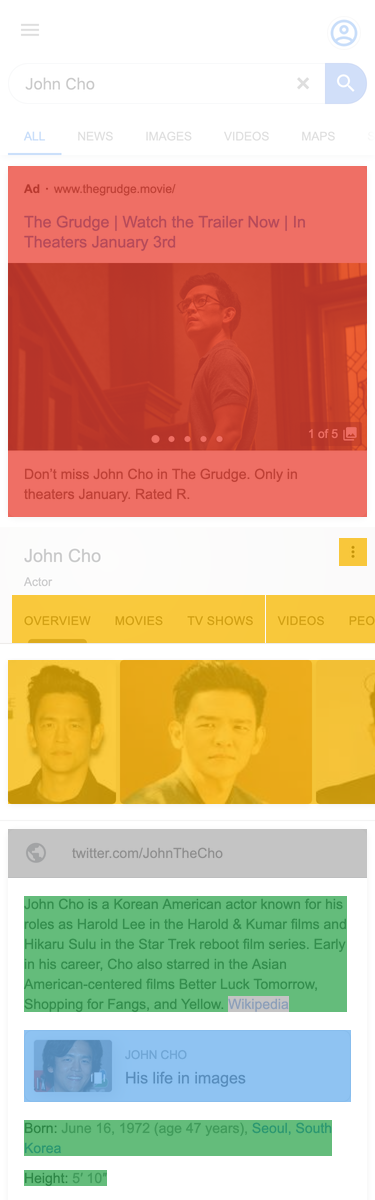

In [16]:
Image.open(fn_stained_screenshot).crop([0, 0, 375, 1200])

In [17]:
# let's close the driver.
assay.close_driver()